# Location selection demo

In [145]:

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

plt.ion()

n = 20


## Helper functions

In [146]:

def generate_cities(n, seed):
    random.seed(seed)
    # Generate n cities with random coordinates
    cities = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    return cities

def calculate_distance(city1, city2):
    # Calculate Euclidean distance between two cities
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def create_popuations(n):
    populations = np.array([(random.triangular(-1, 1)**2)*1000 for _ in range(n)]).round() * 100
    return populations


def create_adjacency_matrix(cities):
    n = len(cities)
    adjacency_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                adjacency_matrix[i][j] = calculate_distance(cities[i], cities[j])
    
    return adjacency_matrix

def plot_cities(cities, marker_downscale_factor):

    margin = 0.05

    # Plot the cities on a Cartesian coordinate system
    city_coords = cities.loc[:,["lat", "long"]].values
    x_coords, y_coords = zip(*city_coords)

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, color='blue', s=cities.loc[:,"pop"]/marker_downscale_factor)
    
    for idx, city in cities.iterrows():
        plt.annotate(city["city"], (city["lat"], city["long"]), textcoords="offset points", xytext=(0,10), ha='center')


    min_x = min(x_coords) - margin
    max_x = max(x_coords) + margin
    min_y = min(y_coords) - margin
    max_y = max(y_coords) + margin

    plt.title('Mobile Clinic Service Region')
    plt.xlabel('Lat')
    plt.ylabel('Long')
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid()
    plt.show()


## Setting up data

In [147]:

from slugify import slugify

def no_nan(val):
    if pd.isna(val):
        return ""
    else:
        return str(val)

home = "Ada"
# Read the adjacency matrix 
adjacencies = pd.read_csv("adjacencyMatrix.csv", index_col=0)
dist2home = adjacencies.loc[:,[home]].rename(columns={home:"dist2home"})
dist2home.index.name = "city"

# Read the cities 
cities = pd.read_csv("cities.csv")
sites = pd.read_csv("sites.csv")

# Create event table
events = pd.merge(cities,sites,on="city")
events.loc[:,"expectedAttendance"] = events.loc[:,"pop"] * events.loc[:,"attendanceRate"]

events.loc[:, "event_id"] = events.apply(lambda row: slugify(f'{row["city"]} {row["site"]} {no_nan(row["event"])}'), axis=1)

# Add the distance to home for each event 
events = pd.merge(events, dist2home, on="city")

events

,city,lat,long,pop,site,event,attendanceRate,expectedAttendance,event_id,dist2home
0,Ada,40.768056,-83.825278,5334,Public Library,NaN,0.002,10.668,ada-public-library,0.0
1,Lima,40.746389,-84.123333,35579,Mercy Health Thrift,NaN,0.002,71.158,lima-mercy-health-thrift,16.2
2,Lima,40.746389,-84.123333,35579,Habitat For Humanity,NaN,0.002,71.158,lima-habitat-for-humanity,16.2
3,Lima,40.746389,-84.123333,35579,Our Daily Bread,NaN,0.002,71.158,lima-our-daily-bread,16.2
4,Lima,40.746389,-84.123333,35579,St. Mark’s Methodist,Community Meal,0.002,71.158,lima-st-marks-methodist-community-meal,16.2
5,Lima,40.746389,-84.123333,35579,Christian Corner Community Center,NaN,0.002,71.158,lima-christian-corner-community-center,16.2
6,Kenton,40.646667,-83.622500,7947,Seton Hall,NaN,0.002,15.894,kenton-seton-hall,15.5
7,Kenton,40.646667,-83.622500,7947,Hardincrest,NaN,0.002,15.894,kenton-hardincrest,15.5
8,Kenton,40.646667,-83.622500,7947,YMCA,NaN,0.002,15.894,kenton-ymca,15.5
9,Delphos,40.861111,-84.350000,7117,Public Library,NaN,0.002,14.234,delphos-public-library,31.8


## Plot cities

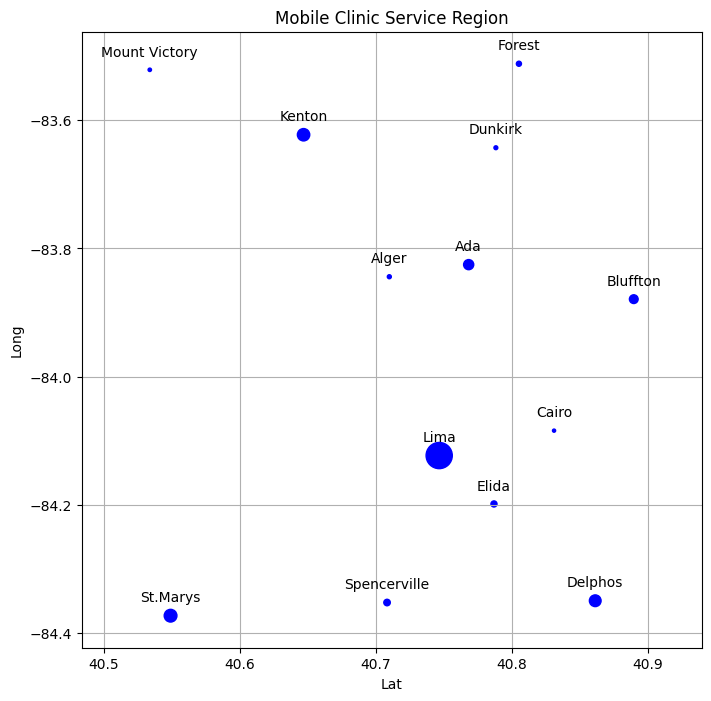

In [148]:
%matplotlib inline 
city_coords = cities.loc[:, ["lat","long"]].values

adjacency_matrix = create_adjacency_matrix(city_coords)

marker_downscale_factor = 100

plot_cities(cities, marker_downscale_factor)


## Representation of problem

In [149]:
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import NSGA3

class clinicOptimization(Problem):

    def __init__(self, events, max_events, min_atp, home, driver_fee, adjacencies, gas_price):
        event_n = events.shape[0] 
        super().__init__(n_var=event_n, n_obj=4, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.max_events = max_events
        self.cities = events.loc[:,"city"]
        self.events = events
        self.expectected_attendance = events.loc[:,"expectedAttendance"].values
        self.min_atp = min_atp
        self.home = home
        self.driver_fee = driver_fee
        self.adj_mat = adjacencies
        self.gas_price = gas_price



    def _evaluate(self, x, out, *args, **kwargs):
        x_bool = x < 0.5
        np.multiply(x_bool, self.expectected_attendance)

        visited_per_solution = np.multiply(x_bool, self.expectected_attendance )

        # Objective 1: Maximize total population visited 
        total_pop_visited = visited_per_solution.sum(axis=1)

        # Objective 2: Maximize the total number of cities visited 
        total_cities_visited = np.apply_along_axis(lambda event_mask: self.events.loc[event_mask, "city"].unique().shape[0], 1, x_bool)

        # Objective 3: Minimize the total number of events that are overstaffed
        overstaffed_events = np.logical_and(visited_per_solution < self.min_atp, visited_per_solution != 0)
        total_overstaffed_events = overstaffed_events.sum(axis=1)

        # Objective 4: Minimize costs 
        gas_costs = np.apply_along_axis(lambda event_mask: self.events.loc[event_mask, "dist2home"].sum(), 1, x_bool) * self.gas_price * 2
        # TODO driver fee
        total_travel_costs = gas_costs


        # Wrap up our objectives all nice and pretty
        out["F"] = np.column_stack([
            -total_pop_visited,              # max
            -total_cities_visited,           # max
            total_overstaffed_events,        # min
            total_travel_costs               # min
            ])       

        # Constrains: Total cities visited
        out["G"] =  total_cities_visited - self.max_events




## Run optimization

In [ ]:

import pandas as pd

# atp = attendees per site, or what is the fewest number of attendees to 
#       guarantee the student trainees get meaningful interactions with patients
min_atp = 15
max_events = 8
dollars_per_mile = 3.00
mpg = 6

prob = clinicOptimization(events, 8, min_atp, home, 800, adjacencies, dollars_per_mile)

ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=4)

algorithm = NSGA3(pop_size=200,
                  ref_dirs=ref_dirs)

res = minimize(prob,
               algorithm,
               ('n_gen', 100),
               verbose=False)


# Get a list of the cities that were visited (decision variables)
locations_visited_bool = res.X < 0.5

locations_visited = []
for lvb in locations_visited_bool: 
    locations_visited.append("\n".join(events.loc[lvb, "event_id"].values))


# Package up the results nicely 
results = pd.DataFrame(res.F, 
                       columns=["Total Patients Served", "Total Cities visited", "Number of over staffed events", "Total Travel Costs"])
results.loc[:,"Total Patients Served"] = np.abs(results.loc[:,"Total Patients Served"])
results.loc[:,"Total Cities visited"] = np.abs(results.loc[:,"Total Cities visited"])
results.loc[:,"Visited cities"] = locations_visited

results

In [ ]:
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

x = results.loc[:,"Total Patients Served"]
y = results.loc[:,"Total Cities visited"]
z = results.loc[:,"Number of over staffed events"]
w = results.loc[:,"Total Travel Costs"]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=w)

ax.set_xlabel("Total patients served")
ax.set_ylabel("Total cities visited")
ax.set_zlabel("Number of overstaffed events")

cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Total Travel Costs')  # Label for the color bar

plt.show()